In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/te-v3-model/model_epoch_70.pt
/kaggle/input/5way-5shot/train_LSA64_5way_5shot_suppot_query.csv
/kaggle/input/5way-5shot/test_LSA64_5way_5shot_suppot_query.csv


In [66]:
from sklearn.metrics import accuracy_score,silhouette_score 
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import csv
import ast
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
import random
from torch.optim import Adam
from torch.nn.functional import cross_entropy
import pandas as pd
from sklearn.model_selection import train_test_split

In [67]:
# Your code for loading the data (unchanged)
input_file = "/kaggle/input/5way-5shot/train_LSA64_5way_5shot_suppot_query.csv"

values = []
matrix_labels = []
num_rows = 0

with open(input_file, "r") as f_input:
    reader = csv.reader(f_input)
    for row in reader:
        row_values = []
        for i in range(len(row) - 1):
            column_value = ast.literal_eval(row[i])
            row_values.append(column_value)
        values.append(torch.tensor(row_values))
        matrix_labels.append(ast.literal_eval(row[-1]))
        num_rows += 1
        
matrix_labels = np.array(matrix_labels)

In [68]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_features, d_model=32, nhead=32, num_layers=1):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(n_features, d_model)
        self.positional_encoding = self.generate_positional_encoding(d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead), num_layers
        )

    def generate_positional_encoding(self, d_model, max_len=243):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.positional_encoding[:, : x.size(1)]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return x

In [69]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        z_proto: torch.Tensor,
        query_set: torch.Tensor,
    ) -> torch.Tensor:

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

In [70]:
train_values = torch.stack(values)
train_matrix_labels = matrix_labels

In [71]:
# Load the saved TransformerEncoder model
saved_model_path = "/kaggle/input/te-v3-model/model_epoch_70.pt"

# Instantiate the TransformerEncoder as the backbone
n_features = 114
encoder = TransformerEncoder(n_features=n_features)
encoder.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [72]:
model = PrototypicalNetworks(encoder)

In [73]:
def create_few_shot_task(values, labels, n_way, k_shot, n_query):
    unique_labels = np.unique(labels)
    selected_labels = np.random.choice(unique_labels, n_way, replace=False)
    
    # Create a dictionary for mapping the original labels to the new labels
    label_map = {label: idx for idx, label in enumerate(selected_labels)}
    
    support_set = []
    query_set = []
    support_labels = []
    query_labels = []
    
    for label in selected_labels:
        class_values = values[labels == label]
        if len(class_values) < k_shot + n_query:
            continue
        support_indices = np.random.choice(range(len(class_values)), k_shot, replace=False)
        query_indices = np.random.choice(np.delete(range(len(class_values)), support_indices), n_query, replace=False)
        
        support_set.append(class_values[support_indices].detach().numpy())
        query_set.append(class_values[query_indices].detach().numpy())
        support_labels.extend([label_map[label]] * k_shot)
        query_labels.extend([label_map[label]] * n_query)
    
    support_set = np.concatenate(support_set, axis=0)
    query_set = np.concatenate(query_set, axis=0)
    support_labels = np.array(support_labels)
    query_labels = np.array(query_labels)
    
    return support_set, query_set, support_labels, query_labels


In [74]:
# Training parameters
n_epochs = 100
n_way = 5
k_shot = 5
n_query = 5
lr = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(n_epochs):
    print(f"Epoch: {epoch + 1}/{n_epochs}")

    support_set, query_set, support_labels, query_labels = create_few_shot_task(train_values, np.array(train_matrix_labels), n_way, k_shot, n_query)
    support_set = torch.tensor(support_set, dtype=torch.float32)
    query_set = torch.tensor(query_set, dtype=torch.float32)
    support_labels = torch.tensor(support_labels, dtype=torch.long)
    
    # Extract the features of support and query images
    z_support = model.backbone.forward(support_set)
    z_query = model.backbone.forward(query_set)

    # Infer the number of different classes from the labels of the support set
    n_way = len(torch.unique(support_labels))
    # Prototype i is the mean of all instances of features corresponding to labels == i
    z_proto = torch.cat(
        [
            z_support[torch.nonzero(support_labels == label)].mean(0)
            for label in range(n_way)
        ]
    )
    
    model.train()
    optimizer.zero_grad()
    scores = model(z_proto,query_set)
    loss = criterion(scores, torch.tensor(query_labels, dtype=torch.long))

    loss.backward()
    optimizer.step()
    
    # Compute accuracy
    _, predictions = torch.max(scores, 1)
    
    accuracy = accuracy_score(query_labels, predictions.detach().numpy())
    
    # Calculate Silhouette Coefficient using both support and query embeddings
    with torch.no_grad():
        support_embeddings = model.backbone.forward(support_set)
        query_embeddings = model.backbone.forward(query_set)
    
    combined_embeddings = np.concatenate((support_embeddings.detach().numpy(), query_embeddings.detach().numpy()), axis=0)
    combined_labels = np.concatenate((support_labels.numpy(), query_labels), axis=0)

    if n_way >= 2:  # Calculate Silhouette Coefficient only if there are at least two classes
        silhouette_coefficient = silhouette_score(combined_embeddings, combined_labels)
        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}, Accuracy: {accuracy * 100}%, Silhouette Coefficient: {silhouette_coefficient}")
    else:
        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}, Accuracy: {accuracy * 100}%")


Epoch: 1/100
Epoch: 1, Loss: 0.9956552386283875, Accuracy: 64.0%, Silhouette Coefficient: 0.1973201036453247
Epoch: 2/100
Epoch: 2, Loss: 0.8163729906082153, Accuracy: 80.0%, Silhouette Coefficient: 0.25077903270721436
Epoch: 3/100
Epoch: 3, Loss: 0.779201865196228, Accuracy: 76.0%, Silhouette Coefficient: 0.2782433331012726
Epoch: 4/100
Epoch: 4, Loss: 0.6156303286552429, Accuracy: 84.0%, Silhouette Coefficient: 0.3117447793483734
Epoch: 5/100
Epoch: 5, Loss: 0.5871668457984924, Accuracy: 76.0%, Silhouette Coefficient: 0.3311294913291931
Epoch: 6/100
Epoch: 6, Loss: 0.5409172177314758, Accuracy: 80.0%, Silhouette Coefficient: 0.348283052444458
Epoch: 7/100
Epoch: 7, Loss: 0.5535069704055786, Accuracy: 84.0%, Silhouette Coefficient: 0.3581828773021698
Epoch: 8/100
Epoch: 8, Loss: 0.449329674243927, Accuracy: 88.0%, Silhouette Coefficient: 0.3675104081630707
Epoch: 9/100
Epoch: 9, Loss: 0.43749552965164185, Accuracy: 80.0%, Silhouette Coefficient: 0.3666113615036011
Epoch: 10/100
Epoch:

In [75]:
# Your code for loading the data (unchanged)
input_file = "/kaggle/input/5way-5shot/test_LSA64_5way_5shot_suppot_query.csv"

values = []
matrix_labels = []
num_rows = 0

with open(input_file, "r") as f_input:
    reader = csv.reader(f_input)
    for row in reader:
        row_values = []
        for i in range(len(row) - 1):
            column_value = ast.literal_eval(row[i])
            row_values.append(column_value)
        values.append(torch.tensor(row_values))
        matrix_labels.append(ast.literal_eval(row[-1]))
        num_rows += 1
        
matrix_labels = np.array(matrix_labels)

In [76]:
test_values = torch.stack(values)
test_matrix_labels = matrix_labels

In [79]:
# Set the number of evaluation episodes
n_evaluation_episodes = 100

# Initialize the accuracy accumulator
total_accuracy = 0

# Set the model to evaluation mode
model.eval()

# Evaluation loop
for episode in range(n_evaluation_episodes):
    support_set, query_set, support_labels, query_labels = create_few_shot_task(test_values, np.array(test_matrix_labels), n_way, k_shot, n_query)
    support_set = torch.tensor(support_set, dtype=torch.float32)
    query_set = torch.tensor(query_set, dtype=torch.float32)
    support_labels = torch.tensor(support_labels, dtype=torch.long) 
    
    # Extract the features of support and query images
    z_support = model.backbone.forward(support_set)
    z_query = model.backbone.forward(query_set)

    # Infer the number of different classes from the labels of the support set
    n_way = len(torch.unique(support_labels))
    # Prototype i is the mean of all instances of features corresponding to labels == i
    z_proto = torch.cat(
        [
            z_support[torch.nonzero(support_labels == label)].mean(0)
            for label in range(n_way)
        ]
    )

    with torch.no_grad():
        scores = model(z_proto, query_set)

        # Compute accuracy
        _, predictions = torch.max(scores, 1)

        accuracy = accuracy_score(query_labels, predictions.detach().numpy())
        print(accuracy)
        # Calculate Silhouette Coefficient
        with torch.no_grad():
            support_embeddings = model.backbone.forward(support_set)
            query_embeddings = model.backbone.forward(query_set)
    
        combined_embeddings = np.concatenate((support_embeddings.detach().numpy(), query_embeddings.detach().numpy()), axis=0)
        combined_labels = np.concatenate((support_labels.numpy(), query_labels), axis=0)

        silhouette_coefficient = silhouette_score(combined_embeddings, combined_labels)
        total_accuracy += accuracy
        print("Accuracy: {:.2%}, Silhouette Coefficient: {:.2f}".format(accuracy, silhouette_coefficient))

# Compute the average accuracy over all evaluation episodes
average_accuracy = total_accuracy / n_evaluation_episodes
print(f"Average accuracy: {average_accuracy * 100}%")

0.8
Accuracy: 80.00%, Silhouette Coefficient: 0.35
0.96
Accuracy: 96.00%, Silhouette Coefficient: 0.41
0.88
Accuracy: 88.00%, Silhouette Coefficient: 0.38
0.92
Accuracy: 92.00%, Silhouette Coefficient: 0.47
1.0
Accuracy: 100.00%, Silhouette Coefficient: 0.39
0.88
Accuracy: 88.00%, Silhouette Coefficient: 0.33
0.96
Accuracy: 96.00%, Silhouette Coefficient: 0.45
0.96
Accuracy: 96.00%, Silhouette Coefficient: 0.49
0.84
Accuracy: 84.00%, Silhouette Coefficient: 0.37
0.88
Accuracy: 88.00%, Silhouette Coefficient: 0.41
0.88
Accuracy: 88.00%, Silhouette Coefficient: 0.43
0.8
Accuracy: 80.00%, Silhouette Coefficient: 0.40
0.96
Accuracy: 96.00%, Silhouette Coefficient: 0.45
1.0
Accuracy: 100.00%, Silhouette Coefficient: 0.48
0.92
Accuracy: 92.00%, Silhouette Coefficient: 0.42
1.0
Accuracy: 100.00%, Silhouette Coefficient: 0.53
0.84
Accuracy: 84.00%, Silhouette Coefficient: 0.43
0.92
Accuracy: 92.00%, Silhouette Coefficient: 0.42
0.92
Accuracy: 92.00%, Silhouette Coefficient: 0.48
0.88
Accuracy:

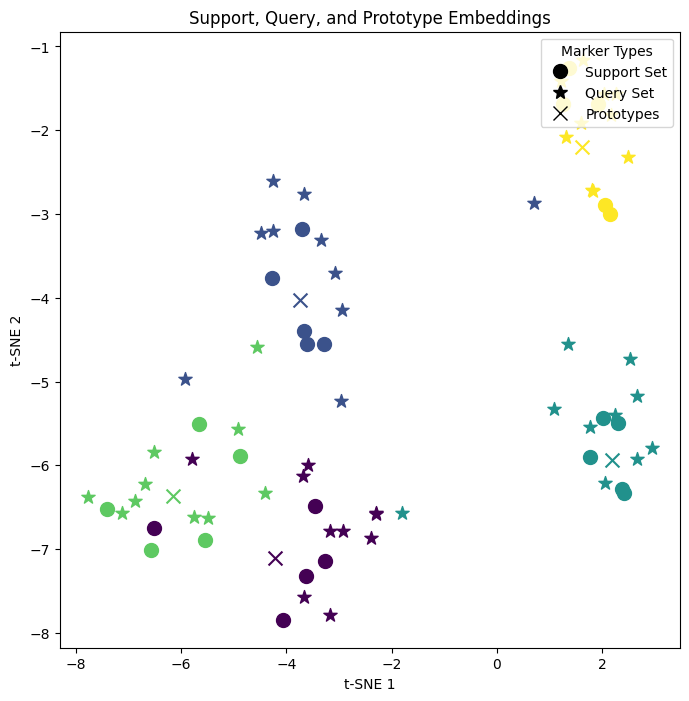

In [78]:
def visualize_embeddings(embeddings, labels, markers, title):
    # Apply t-SNE for dimensionality reduction to 2D
    tsne = TSNE(n_components=2)
    embeddings_tsne = tsne.fit_transform(embeddings)
    
    # Set up the figure for plotting
    fig, ax = plt.subplots(figsize=(8, 8))

    # Set up the color map (one color per class)
    cmap = plt.cm.get_cmap('viridis', len(np.unique(labels)))

    # Create an empty list to store legend handles
    legend_handles = []

    # Iterate through the unique labels to create a legend handle for each class
    for label in np.unique(labels):
        legend_handles.append(
            plt.Line2D(
                [0],
                [0],
                marker='o',
                color=cmap(label),
                label=f'Class {label}',
                markerfacecolor=cmap(label),
                markersize=8,
                linestyle='None'
            )
        )

    # Add the legend for the classes
    ax.legend(handles=legend_handles, loc='upper left', title='Classes')

    for idx, (embedding, label, marker) in enumerate(zip(embeddings_tsne, labels, markers)):
        ax.scatter(*embedding, c=[cmap(label)], marker=marker, s=100)

    # Add a legend for the marker types
    support_marker = plt.Line2D([], [], color='k', marker='o', linestyle='None', markersize=10, label='Support Set')
    query_marker = plt.Line2D([], [], color='k', marker='*', linestyle='None', markersize=10, label='Query Set')
    prototype_marker = plt.Line2D([], [], color='k', marker='x', linestyle='None', markersize=10, label='Prototypes')

    ax.legend(handles=[support_marker, query_marker, prototype_marker], loc='upper right', title='Marker Types')

    # Configure plot appearance
    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    plt.show()

support_set, query_set, support_labels, query_labels = create_few_shot_task(test_values, np.array(test_matrix_labels), n_way, k_shot, 10)
support_set = torch.tensor(support_set, dtype=torch.float32)
query_set = torch.tensor(query_set, dtype=torch.float32)
support_labels = torch.tensor(support_labels, dtype=torch.long) 


# Extract embeddings and labels for support set, query set, and prototypes
support_embeddings = model.backbone(support_set)

z_proto = torch.cat(
            [
                support_embeddings[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

support_embeddings = support_embeddings.detach().numpy()
query_embeddings = model.backbone(query_set).detach().numpy()
prototype_embeddings = z_proto.detach().numpy()

# Create markers for support set ('o'), query set ('*'), and prototypes ('x')
support_markers = ['o'] * len(support_labels)
query_markers = ['*'] * len(query_labels)
prototype_markers = ['x'] * len(np.unique(support_labels))

# Concatenate support, query, and prototype data
all_embeddings = np.concatenate([support_embeddings, query_embeddings, prototype_embeddings], axis=0)
all_labels = np.concatenate([support_labels, query_labels, np.unique(support_labels)], axis=0)
all_markers = support_markers + query_markers + prototype_markers

# Visualize the embeddings
visualize_embeddings(all_embeddings, all_labels, all_markers, "Support, Query, and Prototype Embeddings")